Modules found on network:
S5-3 | S-0038
S5-3 | S-0009
S5-3 | S-0033
S5-3 | S-0036
S5-3 | S-0025
S5-3 | S-0016
Teach-In Started...
Recording...
Recording done.
Recorded 930 samples.


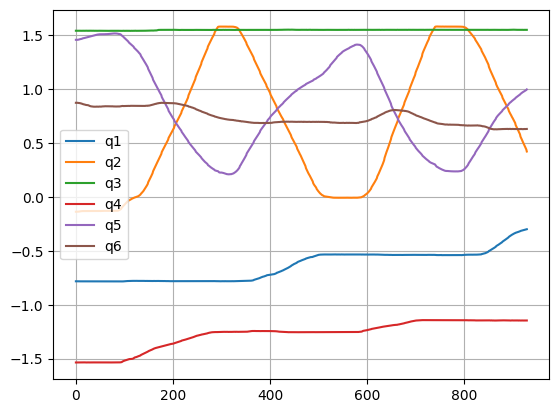

Replay Started...
Finished Replay.
Program Finished.


In [1]:
import hebi
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt

# Initialize HEBI Lookup
lookup = hebi.Lookup()
sleep(2)  # Allow time to discover modules

print('Modules found on network:')
for entry in lookup.entrylist:
    print(f'{entry.family} | {entry.name}')

group = lookup.get_group_from_names(['S5-3'], ['S-0033', 'S-0009', 'S-0025', 'S-0036', 'S-0038', 'S-0016'])
if group is None:
    raise RuntimeError("Group could not be found!")


# Command settings
group_command = hebi.GroupCommand(group.size)
group_feedback = hebi.GroupFeedback(group.size)

# Define parameters
frequency = 100  # Hz
recording_time = 10  # seconds
time_step = 1 / frequency  # time step based on frequency

# Preallocate Q for position data
Q = np.zeros((int(recording_time * frequency), group.size))
row = 0

# Record trajectory
print('Teach-In Started...')
print('Recording...')
start_time = time()
while (time() - start_time) < recording_time:
    # Get feedback
    group.get_next_feedback(reuse_fbk=group_feedback)
    Q[row, :] = group_feedback.position
    row += 1
    
    # Send zero effort command
    group_command.effort = np.zeros(group.size)
    group.send_command(group_command)
    
    # Sleep for the rest of the time step
    sleep(time_step)

print('Recording done.')
print(f'Recorded {row} samples.')

# Trim Q to remove unused rows
Q = Q[:row, :]

# Plot the trajectory
plt.plot(Q)
plt.legend([f'q{i+1}' for i in range(group.size)])
plt.grid(True)
plt.show()

# Pause before playback
sleep(5)
print('Replay Started...')

# Replay recorded trajectory in reverse
for i in range(row-1, -1, -1):
    group_command.position = Q[i, :]
    group.send_command(group_command)
    sleep(time_step)

print('Finished Replay.')

# Reset and finalize
print('Program Finished.')


In [6]:
print(Q.shape)

(930, 6)


In [7]:
# Example joint angle data (replace with real data if available)

def hebi_transformed_matrix(link_length, theta):
    return np.array([[0, -np.cos(theta), np.sin(theta), link_length * np.sin(theta)],
                     [1, 0, 0, 0],
                     [0, np.sin(theta), np.cos(theta), link_length * np.cos(theta)],
                     [0, 0, 0, 1]])


In [10]:
import numpy as np
import pandas as pd

# Length of each link
link_length = 7.0

# Lists to store the origin positions and axis direction vectors for each link
positions = []  # Origin position of each link
x_axes = []     # x-axis direction vector of each link
y_axes = []     # y-axis direction vector of each link
z_axes = []     # z-axis direction vector of each link

# Calculations for each frame in Q
for frame in Q:
    # Joint angles for each link
    theta1, theta2, theta3, theta4, theta5, theta6 = frame
    
    # Transformation matrix for each link
    T12 = hebi_transformed_matrix(link_length, theta1)
    T23 = hebi_transformed_matrix(link_length, theta2)
    T34 = hebi_transformed_matrix(link_length, theta3)
    T45 = hebi_transformed_matrix(link_length, theta4)
    T56 = hebi_transformed_matrix(link_length, theta5)
    T6e = hebi_transformed_matrix(link_length, theta6)
    
    # Calculating positions and axis directions for each link
    transformations = [T12, T23, T34, T45, T56, T6e]
    T_current = np.eye(4)  # Initial transformation matrix (base coordinate system)

    # Lists to store the origin position and axis directions for each link in the current frame
    frame_positions = []
    frame_x_axes = []
    frame_y_axes = []
    frame_z_axes = []

    for T in transformations:
        T_current = T_current @ T  # Update the current transformation matrix

        # Get origin position
        origin = T_current[:3, 3]  # Current origin coordinates
        frame_positions.append(origin)

        # Get each axis direction vector
        x_axis = T_current[:3, 0]  # x-axis direction vector
        y_axis = T_current[:3, 1]  # y-axis direction vector
        z_axis = T_current[:3, 2]  # z-axis direction vector
        frame_x_axes.append(x_axis)
        frame_y_axes.append(y_axis)
        frame_z_axes.append(z_axis)

    # Add data for the current frame
    positions.append(frame_positions)
    x_axes.append(frame_x_axes)
    y_axes.append(frame_y_axes)
    z_axes.append(frame_z_axes)

# Convert results to arrays for easier handling
positions = np.array(positions)  # Origin positions for each link
x_axes = np.array(x_axes)        # x-axis direction vector for each link
y_axes = np.array(y_axes)        # y-axis direction vector for each link
z_axes = np.array(z_axes)        # z-axis direction vector for each link

# Create DataFrames to store the data
df_positions = pd.DataFrame({
    f'position_link_{i+1}': list(positions[:, i]) for i in range(positions.shape[1])
})
df_x_axes = pd.DataFrame({
    f'x_axis_link_{i+1}': list(x_axes[:, i]) for i in range(x_axes.shape[1])
})
df_y_axes = pd.DataFrame({
    f'y_axis_link_{i+1}': list(y_axes[:, i]) for i in range(y_axes.shape[1])
})
df_z_axes = pd.DataFrame({
    f'z_axis_link_{i+1}': list(z_axes[:, i]) for i in range(z_axes.shape[1])
})

# Concatenate the DataFrames
df = pd.concat([df_positions, df_x_axes, df_y_axes, df_z_axes], axis=1)

print("DataFrame with positions and axes data:")
print(df)


DataFrame with positions and axes data:
                                    position_link_1  \
0      [-4.9339446577590005, 0.0, 4.96549998632277]   
1     [-4.9349333852099235, 0.0, 4.964517346483999]   
2      [-4.934656407367862, 0.0, 4.964792658432305]   
3      [-4.935603572518756, 0.0, 4.963851062928872]   
4      [-4.936037888698706, 0.0, 4.963419180497534]   
..                                              ...   
925  [-2.0927226645361214, 0.0, 6.6798586698624725]   
926    [-2.088216716629501, 0.0, 6.681268662790706]   
927   [-2.0813048358759123, 0.0, 6.683425033630551]   
928   [-2.0752223636261906, 0.0, 6.685316158679837]   
929   [-2.0636042628094793, 0.0, 6.688911529278478]   

                                       position_link_2  \
0    [-9.821716959548867, -0.9554071586833262, 9.88...   
1    [-9.823646552580769, -0.9558045719949054, 9.88...   
2    [-9.82348637842076, -0.9517699476218635, 9.883...   
3    [-9.825278596721276, -0.9527337855239337, 9.88...   
4    [-9.

In [11]:
df.describe()

,position_link_1,position_link_2,position_link_3,position_link_4,position_link_5,position_link_6,x_axis_link_1,x_axis_link_2,x_axis_link_3,x_axis_link_4,...,y_axis_link_3,y_axis_link_4,y_axis_link_5,y_axis_link_6,z_axis_link_1,z_axis_link_2,z_axis_link_3,z_axis_link_4,z_axis_link_5,z_axis_link_6
count,930,930,930,930,930,930,930,930,930,930,...,930,930,930,930,930,930,930,930,930,930
unique,930,930,930,930,930,930,930,930,930,930,...,930,930,930,930,930,930,930,930,930,930
top,"[-4.9339446577590005, 0.0, 4.96549998632277]","[-9.821716959548867, -0.9554071586833262, 9.88...","[-14.927761777373874, -0.983292804579204, 5.09...","[-15.78190393742257, 5.945845823192238, 5.6036...","[-20.588842380239573, 5.780492766081566, 10.68...","[-19.784483147760653, 5.8841662478509535, 17.6...","[0.0, 1.0, 0.0]","[-0.7093571409032527, 0.0, -0.7048492368227144]","[0.09620257237898577, -0.9906418982838561, -0....","[-0.6772515661183486, -0.13642858860256557, 0....",...,"[-0.6772515661183486, -0.13642858860256557, 0....","[0.7255627887954837, 0.039126338409497224, 0.6...","[-0.04465654492304527, 0.9989550225722588, -0....","[-0.9923718246737304, -0.04323785430097109, 0....","[-0.7048492368227144, 0.0, 0.7093571409032527]","[-0.698253185969981, -0.13648673695476088, 0.7...","[-0.7294349739750008, -0.003983663699411122, -...","[-0.12202030857838501, 0.9898769468244916, 0.0...","[-0.6867054918310004, -0.02362186530152463, 0....","[0.11490846178270256, 0.01481049739562677, 0.9..."
freq,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Box(children=(VBox(children=(FloatSlider(value=0.0, description='param1', max=90.0, min=-90.0), FloatSlider(va…

Button(description='Reset', style=ButtonStyle())

Button(description='Play', style=ButtonStyle())

IntSlider(value=0, description='Frame', max=929, step=5)

Output()

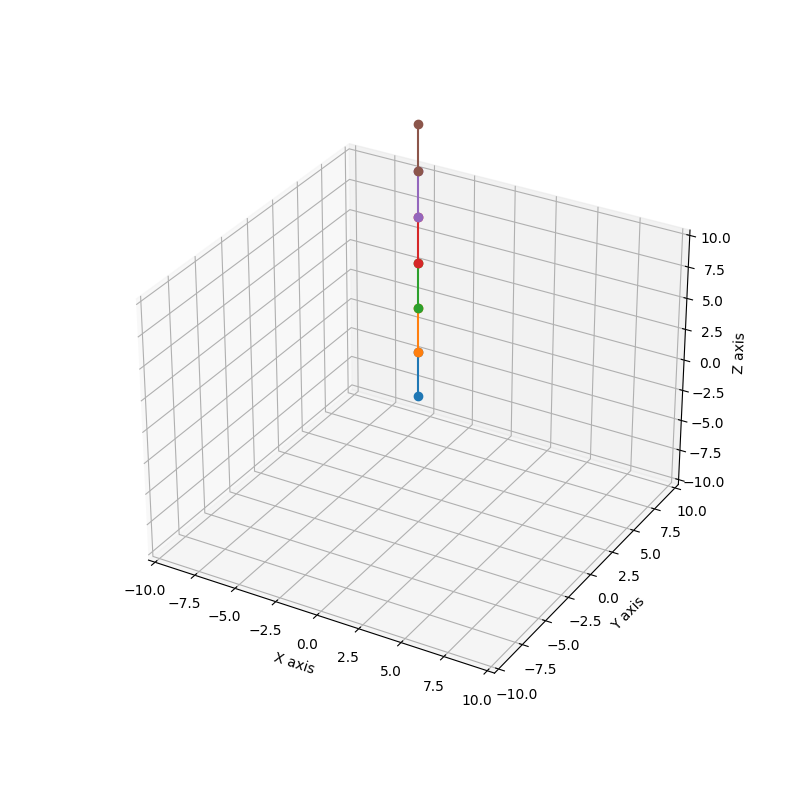

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
from time import sleep
%matplotlib widget

# Example joint angle data (replace with real data if available)

def hebi_transformed_matrix(link_length, theta):
    return np.array([[0, -np.cos(theta), np.sin(theta), link_length * np.sin(theta)],
                     [1, 0, 0, 0],
                     [0, np.sin(theta), np.cos(theta), link_length * np.cos(theta)],
                     [0, 0, 0, 1]])

############# Drawing functions #######################
def init_robot_plot(ax, link_count):
    # Initialize plot lines for each link
    lines = []
    for _ in range(link_count):
        line, = ax.plot([], [], [], "o-", ms=6)  # Create an empty line for each link
        lines.append(line)
    
    # Set plot limits and labels
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-10, 10])
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    
    return lines

def update_robot_plot(lines, points):
    for i, line in enumerate(lines):
        line.set_data([points[i][0, 0], points[i+1][0, 0]], 
                      [points[i][1, 0], points[i+1][1, 0]])
        line.set_3d_properties([points[i][2, 0], points[i+1][2, 0]])

def main(*args, **kwargs):
    params = kwargs
    link_length = 3.5    

    theta_values = [np.deg2rad(params[str(i)]) for i in range(6)]
    matrices = [hebi_transformed_matrix(link_length, theta) for theta in theta_values]

    points = [np.array([[0], [0], [0], [1]])]
    T_current = np.eye(4)

    for T in matrices:
        T_current = T_current @ T
        points.append(T_current @ np.array([[0], [0], [0], [1]]))

    # Update lines without clearing the plot
    update_robot_plot(main.lines, points)
    main.fig.canvas.draw_idle()  # Update canvas more efficiently

def generate_vbox_slider_widget(link_num):
    slider_widgets = []
    for i in range(link_num):
        slider_widgets.append(ipywidgets.FloatSlider(value=0.0, min=-90.0, max=90.0, description=f"param{i+1}", disabled=False))
    return ipywidgets.VBox(slider_widgets)

def update_sliders(frame, sliders):
    # Update each slider with the corresponding value in Q[frame]
    for i, slider in enumerate(sliders.children):
        slider.value = np.rad2deg(Q[frame, i])

def draw_interactive(link_num):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    
    # Initialize robot plot and store lines and fig for updating
    main.lines = init_robot_plot(ax, link_num)
    main.fig = fig

    posture_sliders = generate_vbox_slider_widget(link_num)
    slider_and_text = ipywidgets.Box([posture_sliders])

    reset_button = ipywidgets.Button(description="Reset")
    def reset_values(button):
        for i in range(link_num):
            posture_sliders.children[i].value = 0.0
    reset_button.on_click(reset_values)

    params = {str(i): posture_sliders.children[i] for i in range(link_num)}
    final_widgets = ipywidgets.interactive_output(main, params)

    # Frame control widgets
    play_button = ipywidgets.Button(description="Play")
    frame_slider = ipywidgets.IntSlider(value=0, min=0, max=len(Q)-1, step=5, description="Frame")  # Step size adjusted

    def play_animation(button):
        for frame in range(0, len(Q), 5):  # Skip frames to reduce processing
            update_sliders(frame, posture_sliders)
            frame_slider.value = frame
            sleep(0.05)

    play_button.on_click(play_animation)

    # Update posture sliders when frame slider changes
    def on_frame_slider_change(change):
        update_sliders(change['new'], posture_sliders)
    
    frame_slider.observe(on_frame_slider_change, names="value")

    display(slider_and_text, reset_button, play_button, frame_slider, final_widgets)

draw_interactive(6)


In [ ]:
def cost_func(coef, )